In [35]:
%matplotlib inline  

In [36]:
# system ----
import os
import sys
import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [37]:
snap0 = 84
model = "illustrisTNG"
 
# local ----
localPath = os.path.expanduser("~/")
simPath = os.path.expanduser(localPath+"_simulations/"+model+"/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_005/")
sys.path.append(projPath+"modules")
import plot_parameters 

***

In [38]:
# Load Illustris TNG modules

# ---- simulation parameters 
if(model == "illustris"):
    params = {
         'h0'     : 0.704,
         'omegaM' : 0.2726,
         'omegaL' : 0.7274,
         'omegaB' : 0.0456,
         'omegaR' : 0.0000,
         'boxsize': 106.5
         }
elif(model == "illustrisTNG"):
     params = {
         'h0'     : 0.6774,
         'omegaM' : 0.3089,
         'omegaL' : 0.6911,
         'omegaB' : 0.0486,
         'omegaR' : 0.0000,
         'boxsize': 110.7
         }

# ---- cluster selection
from illustris_python import groupcat
fof_fields = ['Group_M_TopHat200',
              'Group_R_TopHat200',
              'GroupFirstSub',
              'GroupNsubs']
sub_fields = ['SubhaloMass',
              'SubhaloPos',
              'SubhaloLenType',
              'SubhaloMassType']
 
fof = groupcat.loadHalos(simPath+"TNG100_1/output",snap0,fields=fof_fields)
sub = groupcat.loadSubhalos(simPath+"TNG100_1/output",snap0, fields=sub_fields)
h0 = params['h0']

<div class="alert alert-block alert-info">
     <font size="6"> <b> Clustering in Illustris TNG  </b> </font> 
</div>

* We select target halos with mass $M_{\rm vir} \sim 10^{13} M_{\odot}$
* We define <b>resolved</b> subhalos to <b>at least</b> 20 dark matter particles

With $N_{\rm dm}=20$ and $m_{\rm dm} = 7.5 \times 10^{6} M_{\odot}$, the resolved mass will be
\begin{align}
m_{\rm res} = N_{\rm dm}m_{\rm dm} \approx 1.5 \times 10^{8} M_{\odot}
\end{align}

<div class="alert alert-block alert-danger">
TNG100-1 can not resolve down to 20 DM particles based off of the hmf function... so let the resolved mass be $m_{\rm res} = 10^{9} M_{\odot}$, which is about 
</div>

\begin{align}
N_{\rm dm} \approx 133
\end{align}

Let us sample out the target halo samples

In [39]:
# ---- sample out a host halo
Mmin = 8.e+12
Mmax = 2.e+13
mask_ = (( fof['Group_M_TopHat200'] > Mmin*h0/1e+10 ) & ( fof['Group_M_TopHat200'] < Mmax*h0/1e+10 )).nonzero()[0]
mask = mask_[10]

#mask = mask[0]
idh = fof['GroupFirstSub'][mask]
Mhalo = fof['Group_M_TopHat200'][mask] * 1e+10/h0
Rhalo = fof['Group_R_TopHat200'][mask] / h0
nSubs = fof['GroupNsubs'][mask]
hpos = sub["SubhaloPos"][idh]
 
# ---- sample subhalos for prep
resPartNum = 20
min_mass = resPartNum * 7.5e+6
 
import cosmo
cosm = cosmo.Cosmology(**params)

smass_ = sub['SubhaloMass'][:] * 1e+10 / h0
spos_ = sub['SubhaloPos'][:]
slen_ = sub['SubhaloLenType'][:,1]
smass_ = np.delete(smass_,idh,0)
spos_ = np.delete(spos_,idh,0)
slen_ = np.delete(slen_,idh,0)
resolved_mass = ((smass_ > min_mass) & (slen_ >= 20))
smass = smass_[resolved_mass]
srvir = cosm.virial_radius(0.2,smass)
spos = spos_[resolved_mass]

***

***

***

<div class="alert alert-block alert-info">
     <font size="6"> <b> Predicted Occupation Density  </b> </font> 
</div>

We now wish to know how clustered each segment of a given cylinder is. Before we look at the simulation data, let us first quantify this from the predicted analytical mass function. 

<div class="alert alert-block alert-success">
<font size="4"> <b> Press-Schechter Formalism </b> </font> 
</div>

## Halo Mass Function

The standard cumulative number distribution of halos in a given volume is defined by
\begin{align}
n(>M) := f(\sigma) \frac{\rho_{m,0}}{M^{2}}\left| \frac{d\ln \sigma(M,z)}{d\ln M} \right|
\end{align}
or in differential form
\begin{align}
\frac{dn}{d\ln M} := f(\sigma) \frac{\rho_{m,0}}{M}\left| \frac{d\ln \sigma(M,z)}{d\ln M} \right|
\end{align}
where $\sigma \equiv \sigma(M,z)$ is the rms variance in some smoothing region
\begin{align}
\sigma^{2}(M,z) := \int_{0}^{\infty} \frac{dk}{k} \Delta(k,z) \left| \widetilde{W}(k;R) \right|
\end{align}

Here, I have assumed the window function $\widetilde{W}$ to be the form of a top-hat and the normalized linear power spectrum follows its dominate form
\begin{align}
\Delta(k,z) := \frac{\alpha_{8} G(z)}{2\pi^{2}} k^{3+n_{s}}\mathcal{T}^{2}(k)
\end{align}
where $\alpha$ is the normalization constant dictated by the parameters of $\sigma_{8}$, $G(z)$ is the normalized growth factor
\begin{align}
G(z) := \frac{D^{+}(z)}{D^{+}(z=0)}
\end{align}
$n_{s}$ is the spectral index from the primoridal power spectrum, and $\mathcal{T}$ is the input transfer function that assumes the form of Eisenstein & Hu (1998).

A useful quantity to consider is the peak height
\begin{align}
\nu_{\rm vir} = \frac{\delta_{c}}{\sigma(M_{\rm vir}, z)}
\end{align}
where $\delta_c = 1.686$ is the critical overdensity in the spherical collapse model. We consider this due to its tight correlation with the evolution of halo concentration.

In [40]:
# ---- Halo mass function @ z=0.2
sys.path.append(localPath+"_projects/halomassfunction/main")
import hmf_calculate
import power
 
m_arr = 10**np.linspace(np.log10(1e+6), np.log10(1e+15), 50)
hmf_params = {
        'h0' : params['h0'],
        'omegaM' : params['omegaM'],
        'omegaL' : params['omegaL'],
        'omegaB' : params['omegaB'],
        'sigma8' : 0.8159
        }

# call mass functions
nPS = hmf_calculate.Function(fit='press74', transfer_model='eisenstein98', 
                                filter_shape='tophat', **hmf_params).nM(0.2, m_arr)
nST = hmf_calculate.Function(fit='sheth99', transfer_model='eisenstein98', 
                                filter_shape='tophat', **hmf_params).nM(0.2, m_arr)
# call differnetial mass functions
dnPS = hmf_calculate.Function(fit='press74', transfer_model='eisenstein98', 
                                 filter_shape='tophat', **hmf_params).dlnM(0.2, m_arr)
dnST = hmf_calculate.Function(fit='sheth99', transfer_model='eisenstein98', 
                                 filter_shape='tophat', **hmf_params).dlnM(0.2, m_arr)
# call mass variance
mvar = power.Linear(transfer_model='eisenstein98', filter_shape='tophat', **hmf_params).sigma(0.2, m_arr)

# normalize h0 factors
#m_arr *= np.power(h0,-1)
#nPS *= np.power(h0,3)
#nST *= np.power(h0,3)
#dnPS *= np.power(h0,3)
#dnST *= np.power(h0,3)

nu = 1.686/mvar

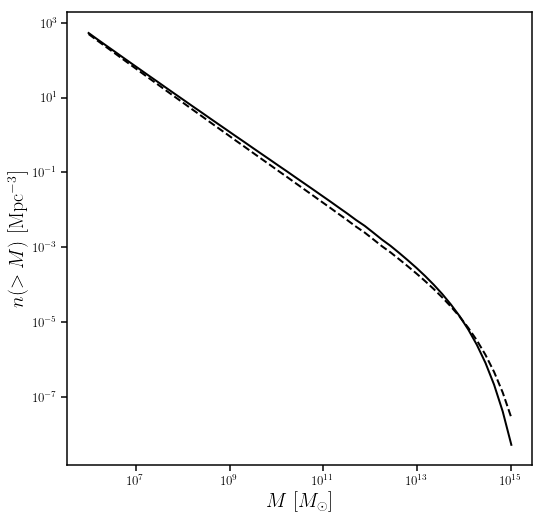

In [41]:
# Cumulative number density
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)
# ---- plotting curves
ax.plot(m_arr, nPS, color='black', ls='-', label='PS74') 
ax.plot(m_arr, nST, color='black', ls='--', label='ST99') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ n(>M)\ [\rm Mpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)
plt.show()

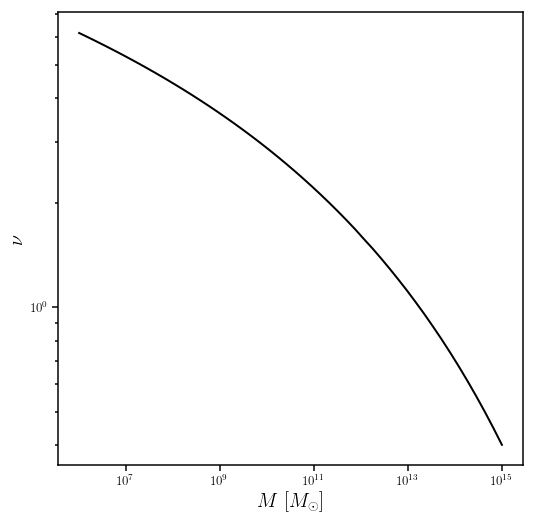

In [42]:
# peak height plotted against mass function
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)
# ---- plotting curves
ax.plot(m_arr, mvar, color='black', ls='-') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ \nu $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)
plt.show()

<div class="alert alert-block alert-warning">
<font size="3"> <b> Being extra careful, we can import Benedikts' COLOSSUS package... </b> </font> 
</div>

In [43]:
# for further checking, we can import Benedikts' Colossus package...
from colossus.cosmology import cosmology
cosmology.setCosmology('planck15');

from colossus.lss import mass_function
col_m = 10**np.arange(7.0, 15, 0.1)

col_PS = mass_function.massFunction(col_m, 0.2, mdef = 'fof', model = 'press74', q_out = 'dndlnM') 
col_ST = mass_function.massFunction(col_m, 0.2, mdef = 'fof', model = 'sheth99', q_out = 'dndlnM') 
col_T08 = mass_function.massFunction(col_m, 0.2, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')

col_m *= np.power(h0,-1)
col_PS *= np.power(h0,3)
col_ST *= np.power(h0,3)
col_T08 *= np.power(h0,3)

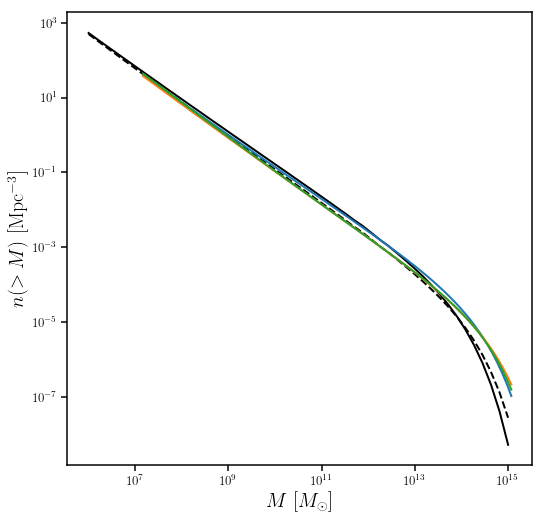

In [44]:
# Cumulative number density
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)
# ---- plotting curves
ax.plot(m_arr, nPS, color='black', ls='-', label='PS74') 
ax.plot(m_arr, nST, color='black', ls='--', label='ST99') 

ax.plot(col_m, col_PS, ls='-') 
ax.plot(col_m, col_ST, ls='-') 
ax.plot(col_m, col_T08, ls='-') 

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ n(>M)\ [\rm Mpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)
plt.show()

***

## Compare IllustrsTNG halos to Analytical Predictions

In [45]:
# As a sanity check we can also plot the mass function inside 
# illustrisTNG against the analytical forms
idh = fof['GroupFirstSub']
Mhalo = fof['Group_M_TopHat200'] * 1e+10/h0
mhalo = sub['SubhaloMass'] * 1e+10/h0
#mhalo = sub['SubhaloMassType'][:,1] * 1e+10/h0
volume = np.power(params['boxsize'],3.)

bin_size = 35
mass_bin = 10**np.linspace(7, np.log10(max(mhalo)), bin_size)
N_bin = np.zeros(bin_size)
for i in range(bin_size):
    mask = (mass_bin[i] < Mhalo)
    N_bin[i] += np.sum(mask)

n_bin = N_bin/volume # Mpc^-3
dn_bin = np.abs(np.gradient(n_bin)/np.gradient(np.log(mass_bin)))

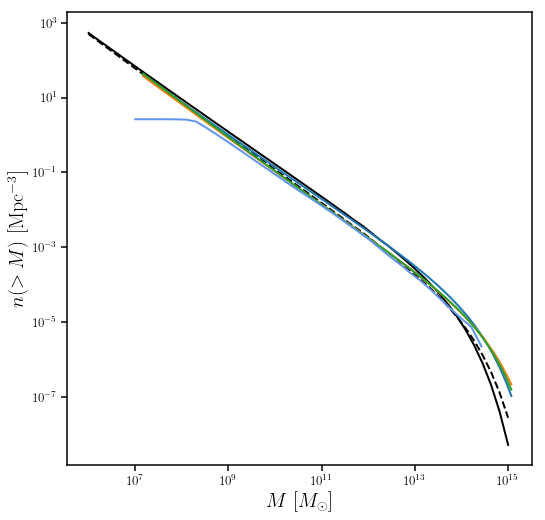

In [46]:
# Cumulative number density w/ simulated halos
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)

# ---- plotting curves
ax.plot(m_arr, nPS, color='black', ls='-') 
ax.plot(m_arr, nST, color='black', ls='--') 

ax.plot(col_m, col_PS, ls='-') 
ax.plot(col_m, col_ST, ls='-') 
ax.plot(col_m, col_T08, ls='-')

ax.plot(mass_bin, n_bin, color='cornflowerblue', ls='-') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ n(>M)\ [\rm Mpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)
plt.show()

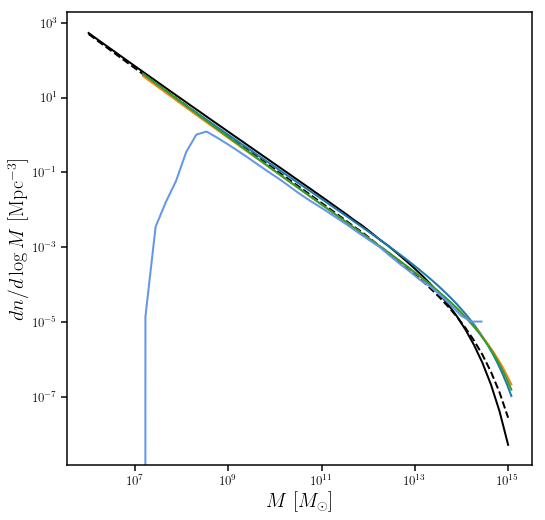

In [47]:
# logarithmic derivative of mass function w/ simulated halos
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)
# ---- plotting curves
ax.plot(m_arr, dnPS, color='black', ls='-') 
ax.plot(m_arr, dnST, color='black', ls='--') 

ax.plot(col_m, col_PS, ls='-') 
ax.plot(col_m, col_ST, ls='-') 
ax.plot(col_m, col_T08, ls='-')

ax.plot(mass_bin, dn_bin, color='cornflowerblue', ls='-') 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ dn / d\log M\ [\rm Mpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)
plt.show()

***

We have previously seen how the halo mass function at $z\sim 0.2$ looks like. Let us compute the predicted number density for all of the resolved halos in the simulation $n(>m_{\rm res})$, where $m_{\rm res} \sim 10^{8} M_{\odot}$

In [48]:
resPartNum = 20
m_cut = resPartNum * 7.5e+6
#n = nPS
n = nST
ncol = col_T08

from scipy.interpolate import CubicSpline
spl_n = CubicSpline(m_arr, n)
spl_ncol = CubicSpline(col_m, ncol)
spl_nbin = CubicSpline(mass_bin, n_bin)

min resolved mass: 150000000.0 Msol
n(>m_res) from ST: 5.154327784438047 Mpc^{-3}
n(>m_res) from Jenkins+(2008): 5.046314089239242 Mpc^{-3}
n(>m_res) from TNG: 2.5123850254715543 Mpc^{-3}


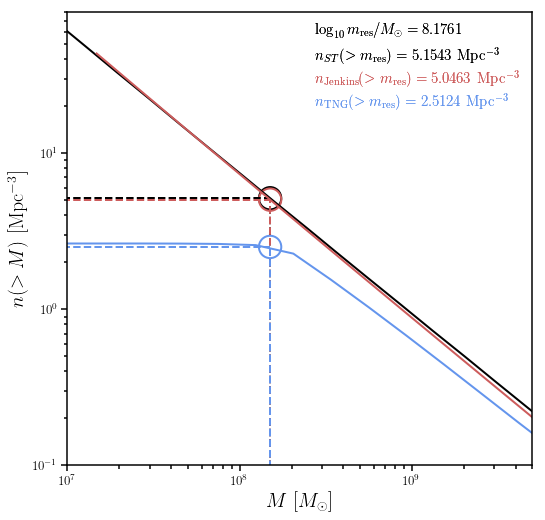

In [49]:
n_cut = spl_n(m_cut)
ncol_cut = spl_ncol(m_cut)
nbin_cut = spl_nbin(m_cut)
print 'min resolved mass:', m_cut, 'Msol'
print 'n(>m_res) from ST:', n_cut, 'Mpc^{-3}'
print 'n(>m_res) from Jenkins+(2008):', ncol_cut, 'Mpc^{-3}'
print 'n(>m_res) from TNG:', nbin_cut, 'Mpc^{-3}'

# Cumulative number density
fig = plt.figure(figsize=(10/1.2,10/1.2))
ax = fig.add_subplot(111)

# ---- plotting curves
ax.plot(m_arr, n, color='black', ls='-') 
ax.scatter(m_cut, n_cut, marker='o', edgecolor='black', facecolor="None", linewidth=2, s=500)
ax.plot(np.linspace(1e5, m_cut), np.linspace(n_cut, n_cut), color='black', ls='--')
ax.plot(np.linspace(m_cut, m_cut), np.linspace(1e-9, n_cut), color='black', ls='--')

ax.plot(col_m, ncol, color='indianred', ls='-') 
ax.scatter(m_cut, ncol_cut, marker='o', edgecolor='indianred', facecolor="None", linewidth=2, s=500)
ax.plot(np.linspace(1e5, m_cut), np.linspace(ncol_cut, ncol_cut), color='indianred', ls='--')
ax.plot(np.linspace(m_cut, m_cut), np.linspace(1e-9, ncol_cut), color='indianred', ls='--')

ax.plot(mass_bin, n_bin, color='cornflowerblue', ls='-') 
ax.scatter(m_cut, nbin_cut, marker='o', edgecolor='cornflowerblue', facecolor="None", linewidth=2, s=500)
ax.plot(np.linspace(1e5, m_cut), np.linspace(nbin_cut, nbin_cut), color='cornflowerblue', ls='--')
ax.plot(np.linspace(m_cut, m_cut), np.linspace(1e-9, nbin_cut), color='cornflowerblue', ls='--')

#ax.set_xlim(1e+7, 1e+15)
#ax.set_ylim(1e-7, 50)

ax.set_xlim(1e+7, 5e+9)
ax.set_ylim(1e-1, 80)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ n(>M)\ [\rm Mpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=20)

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty, empty, empty, empty],
         [r'$\log_{10} m_{\rm res}/M_{\odot} = %0.4f $' % (np.log10(m_cut)),
          r'$n_{ST}(>m_{\rm res})= %0.4f \ \rm Mpc^{-3}$' % (n_cut),
          r'$n_{\rm Jenkins}(>m_{\rm res})= %0.4f \ \rm Mpc^{-3}$' % (ncol_cut), 
          r'$n_{\rm TNG}(>m_{\rm res})= %0.4f \ \rm Mpc^{-3}$' % (nbin_cut)], 
                  loc="upper right",fontsize=15, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
label.get_texts()[1].set_color('black')
label.get_texts()[2].set_color('indianred')
label.get_texts()[3].set_color('cornflowerblue')
ax.add_artist(label)

plt.show()

<div class="alert alert-block alert-danger">
That's not good... the halos that we have defined to be resolved are under-predicted from the mass function curves.
</div>

***

Here, the value above is the number density expected inside the _entire_ volume of the box. The volume of each line-of-sight cylinder follows as

\begin{align}
V_{\rm cyl} = \pi \mathcal{R}^{2} \ell
\end{align}
where $\mathcal{R}$ is the chosed radius of the LOS and $\ell$ is the cylinder length. 

For our target clusters with mass $M_{\rm vir} \sim 10^{13}\ M_{\odot}$, the virial radius follows from the definition of Bryan & Norman (1998)
\begin{align}
M_{\rm vir} \sim 10^{13} M_{\rm halo} \longrightarrow R_{\rm vir} \sim 500\ \rm kpc
\end{align}
For our sample of halos, we have $\langle R_{\rm vir}\rangle \sim 650\ \rm kpc$. 

We can then set our length of the LOS cylinder to be length of the simulation box $\ell = L_{\rm box} = 110\ \mathrm{Mpc} \rightarrow 1.1 \times 10^{5}\ \rm kpc$.

Combining everything, our volume of the cylinder comes out to be...

In [50]:
volCyl_kpc = np.pi * np.average(Rhalo)**2. * params['boxsize'] * 1000.
volCyl_Mpc = volCyl_kpc / np.power(1000.,3)
print volCyl_kpc, 'kpc'  
print volCyl_Mpc, 'Mpc'  

143905240019.00436 kpc
143.90524001900437 Mpc


The expecting number of resolved subhalos inside a confined cylinder is
\begin{align}
N(>m_{\rm res}) &= n(>m_{\rm res}) V_{\rm cyl} \\
&= n(>m_{\rm res}) \times (\pi \mathcal{R}^{2} \ell)
\end{align}

For our case, the unitless number is
\begin{align}
N(>m_{\rm res}) &= n(>m_{\rm res}) \times (\pi R_{\rm vir}^{2} L_{\rm box})
\end{align}
which will then be...

In [51]:
N_cut = volCyl_Mpc * n_cut
print N_cut

741.7347769561802


***

***

***

<div class="alert alert-block alert-info">
     <font size="6"> <b> Simulated Subhalo Occupation in LOS</b> </font> 
</div>


Let us now then see how the simulation stacks up against the predictions. 

* This is done by computed the cumulative number of subhalos in a given cylinder length $\ell$ for each our target clusters in our sample. 
* For each cluster analyzed, a random cylinder is generated
* We have two types of sample distribution
    1. $\langle ... \rangle$ indicated the **averaged** count of all the subhalo: The total number of subhalos in each cylinder bin normalized by the total number of halo clusters.
    2. Else, with no brackets, the stacked total number of subhalos in each cylinder length bin.

For the sake of bravity, the analysis has been done on one of the high memory nodes on the deparments local cluster. After some years later, let us load our sample...

In [52]:
# call analysis results 
outPath = projPath+"/output"

l = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count.txt")[:,0]
ln = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count.txt")[:,1]
xa = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count.txt")[:,5]
ya = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count.txt")[:,6]
za = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count.txt")[:,7]
xra = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count_rand.txt")[:,5]
yra = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count_rand.txt")[:,6]
zra = np.loadtxt(outPath+"/count/nSurvLength_radRvir_count_rand.txt")[:,7]

dl = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope.txt")[:,0]
dln = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope.txt")[:,1]
dxa = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope.txt")[:,5]
dya = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope.txt")[:,6]
dza = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope.txt")[:,7]
dxra = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope_rand.txt")[:,5]
dyra = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope_rand.txt")[:,6]
dzra = np.loadtxt(outPath+"/slope/nSurvLength_radRvir_slope_rand.txt")[:,7]

***

<div class="alert alert-block alert-success">
     <font size="4"> <b> Clustering Distribution Count for radius $\mathcal{R} = R_{\rm vir}$  </b> </font> 
</div>

Let us take a look at the stacked count of the cumulative distributions... but let us first set up our analytical predictions...

In [53]:
_n_cut = ncol_cut

In [54]:
avgR = np.average(Rhalo) # kpc
lBox = params['boxsize']*1000. # kpc

N_ell = np.zeros(len(l))
for i in range(len(l)):
    volume = np.pi * avgR**2. * l[i] * np.power(1.e-3,3) 
    N_ell[i] = _n_cut * volume
    
N_elll = np.cumsum(N_ell)
N_ellg = np.max(N_elll) - N_elll 
dN_ellg = np.gradient(N_elll)/np.gradient(l)

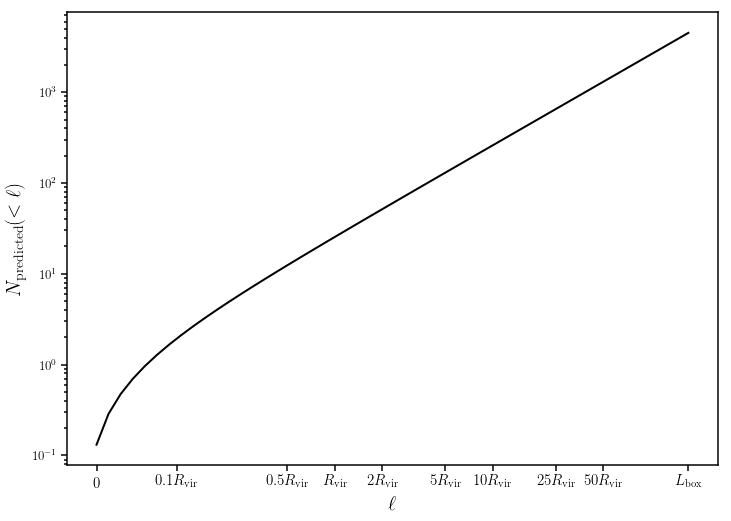

In [55]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(ln, N_elll, color='black')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'$ N_{\rm predicted}(<\ell)$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

ax.set_xticks([min(ln), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', r'$25 R_{\rm vir}$', 
                    r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

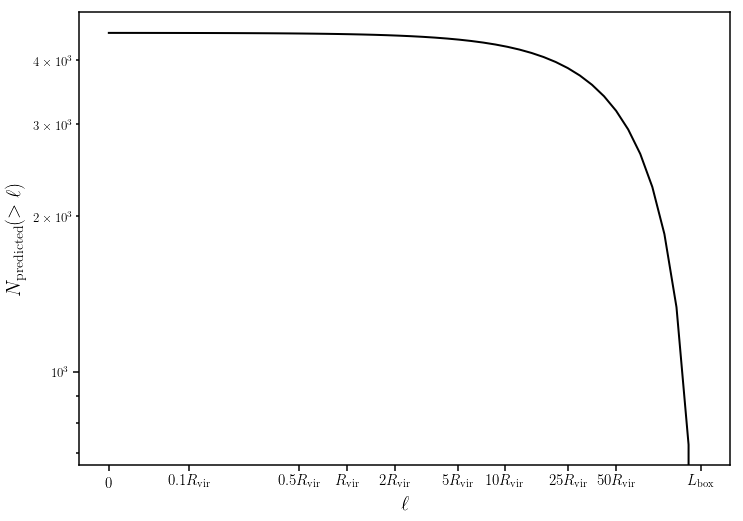

In [56]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(ln, N_ellg, color='black')

ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_ylim(100, 5e+2)

ax.set_ylabel(r'$ N_{\rm predicted}(>\ell)$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# ---- modify tick and axis label
ax.set_xticks([min(ln), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', r'$25 R_{\rm vir}$', 
                    r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

### Average Cumulative Distribution

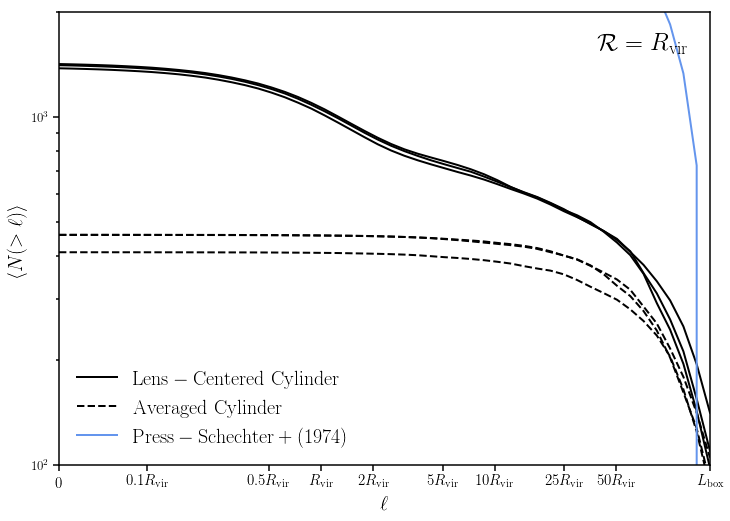

In [57]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(ln, xa, color='black')
ax.plot(ln, ya, color='black')
ax.plot(ln, za, color='black')
ax.plot(ln, xra, ls='--', color='black')
ax.plot(ln, yra, ls='--', color='black')
ax.plot(ln, zra, ls='--', color='black')

ax.plot(ln, N_ellg, color='cornflowerblue')

# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(ln), max(ln))
ax.set_ylim(100, 2000)
 
# ---- modify tick and axis label
ax.set_xticks([min(ln), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', 
                    r'$25 R_{\rm vir}$', r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle N(>\ell) \rangle$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Press-Schechter + (1974)$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Sheth-Tormen + (1999)$')
leg = ax.legend(loc='lower left', frameon=False, fontsize=20)

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'$\mathcal{R} = R_{\rm vir}$'], loc="upper right", ncol=2, 
                  fontsize=25, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(leg)

### Average Cumulative Number Density

In [58]:
Ravg = np.average(Rhalo)
nxa = np.zeros(len(l))
nya = np.zeros(len(l))
nza = np.zeros(len(l))
nxra = np.zeros(len(l))
nyra = np.zeros(len(l))
nzra = np.zeros(len(l))

for i in range(len(l)):
    volume = np.pi * Ravg**2 * l[i]
    nxa[i] += xa[i]/volume
    nya[i] += ya[i]/volume
    nza[i] += za[i]/volume
    nxra[i] += xra[i]/volume
    nyra[i] += yra[i]/volume
    nzra[i] += zra[i]/volume
    
n_ellg = N_ellg/(np.pi * Ravg**2 * lBox) 

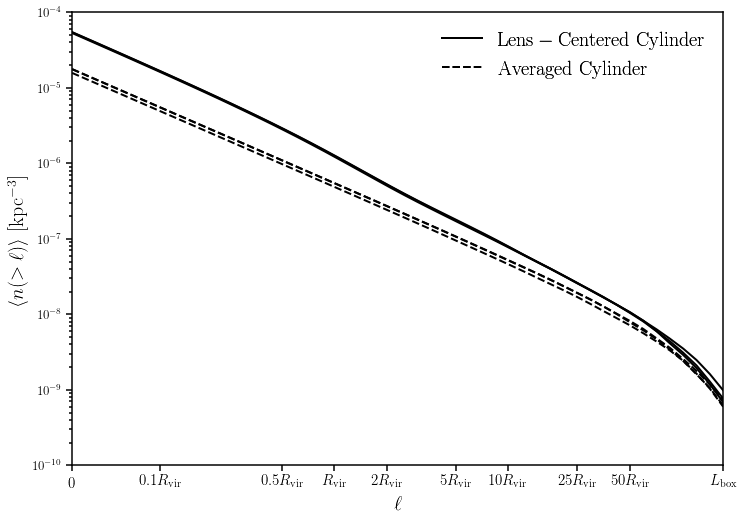

In [59]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(ln, nxa, color='black')
ax.plot(ln, nya, color='black')
ax.plot(ln, nza, color='black')
ax.plot(ln, nxra, ls='--', color='black')
ax.plot(ln, nyra, ls='--', color='black')
ax.plot(ln, nzra, ls='--', color='black')

# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(ln), max(ln))
ax.set_ylim(1e-10, 1e-4)
 
# ---- modify tick and axis label
ax.set_xticks([min(ln), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', 
                    r'$25 R_{\rm vir}$', r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle n(>\ell) \rangle\ [\rm kpc^{-3}] $', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
leg = ax.legend(loc='upper right', frameon=False, fontsize=20)
ax.add_artist(leg)

### Total Differential Cumulative Distribution

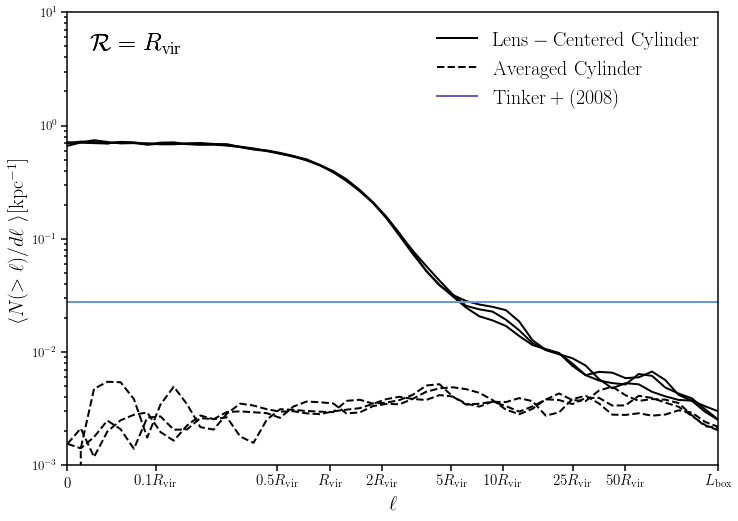

In [60]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(dln, np.abs(dxa), color='black')
ax.plot(dln, np.abs(dya), color='black')
ax.plot(dln, np.abs(dza), color='black')
ax.plot(dln, np.abs(dxra), ls='--', color='black')
ax.plot(dln, np.abs(dyra), ls='--', color='black')
ax.plot(dln, np.abs(dzra), ls='--', color='black')
 
ax.plot(ln, dN_ellg*h0, color='cornflowerblue')
 
# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(ln), max(ln))
ax.set_ylim(1e-3, 10)
 
# ---- modify tick and axis label
ax.set_xticks([min(ln), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', 
                    r'$25 R_{\rm vir}$', r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle N(>\ell) / d\ell\ \rangle [\rm kpc^{-1}] $', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='slateblue', ls='-', label=r'$\rm Press-Schechter + (1974)$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Sheth-Tormen + (1999)$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='slateblue', ls='-', label=r'$\rm Tinker + (2008)$')
leg = ax.legend(loc='upper right', frameon=False, fontsize=20)
ax.add_artist(leg)
 
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'$\mathcal{R} = R_{\rm vir}$'], loc="upper left", ncol=2, 
                  fontsize=25, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)


## How does this look out to 1 Gpc? 
We extrapolate our distributions using the analytical predictions. Here we implemented additional gaussian noise around the median predicted value of the HMF with a STD of $\sim 10^{-3}$

In [61]:
avgR = np.average(Rhalo) # kpc
lBox = params['boxsize'] * 1000. # kpc
ellGpc = 10**np.linspace(0., np.log10(1e+6),50)

N_ellGpc = np.zeros(len(ellGpc))
for i in range(len(ellGpc)):
    volume = np.pi * avgR**2. * ellGpc[i] * np.power(1.e-3,3)
    N_ellGpc[i] = n_cut * volume
    
N_elllGpc = np.cumsum(N_ellGpc)
N_ellgGpc = np.max(N_elllGpc) - N_elllGpc
dN_ellgGpc = np.gradient(N_elllGpc)/np.gradient(ellGpc)

In [62]:
extrap_arr = 10**np.linspace(np.log10(lBox+50000.), np.log10(1e+6),10)
noisex = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))
noisey = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))
noisez = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))
noisexr = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))
noiseyr = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))
noisezr = np.random.normal(max(dN_ellgGpc), 0.0008, len(extrap_arr))

extrap_ell = list(dl) + list(extrap_arr)
ext_dxa = list(np.abs(dxa)) + list(noisex)
ext_dya = list(np.abs(dya)) + list(noisey)
ext_dza = list(np.abs(dza)) + list(noisez)
ext_dxra = list(np.abs(dxra)) + list(noisexr)
ext_dyra = list(np.abs(dyra)) + list(noiseyr)
ext_dzra = list(np.abs(dzra)) + list(noisezr)

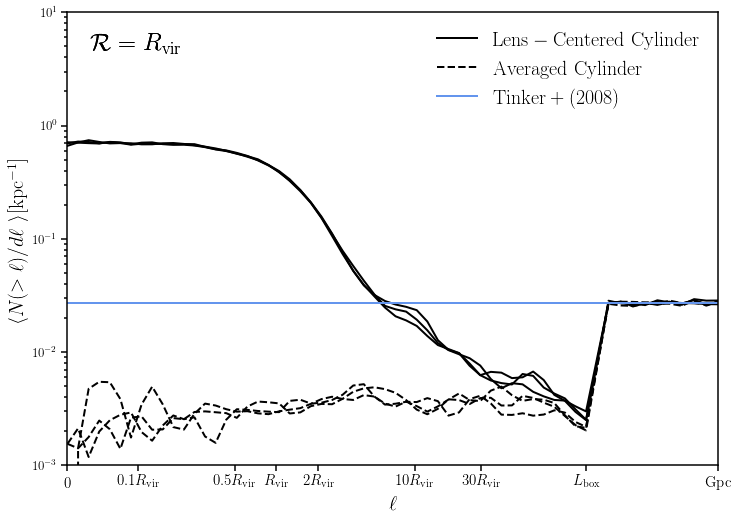

In [70]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(extrap_ell, ext_dxa, color='black')
ax.plot(extrap_ell, ext_dya, color='black')
ax.plot(extrap_ell, ext_dza, color='black')
ax.plot(extrap_ell, ext_dxra, ls='--', color='black')
ax.plot(extrap_ell, ext_dyra, ls='--', color='black')
ax.plot(extrap_ell, ext_dzra, ls='--', color='black')
 
ax.plot(ellGpc, dN_ellgGpc, color='cornflowerblue')
 
# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(l), 1e+6)
ax.set_ylim(1e-3, 10)
 
# ---- modify tick and axis label
ax.set_xticks([min(l), 0.1*avgR, 0.5*avgR, avgR, 2.*avgR,  10.*avgR, 30.*avgR, lBox, 1e+6])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$10 R_{\rm vir}$', r'$30 R_{\rm vir}$', 
                    r'$L_{\rm box}$', r'$\rm Gpc$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle N(>\ell) / d\ell\ \rangle [\rm kpc^{-1}] $', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Press-Schechter + (1974)$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Sheth-Tormen + (1999)$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Tinker + (2008)$')
leg = ax.legend(loc='upper right', frameon=False, fontsize=20)
ax.add_artist(leg)
 
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'$\mathcal{R} = R_{\rm vir}$'], loc="upper left", ncol=2, 
                  fontsize=25, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)


***

<div class="alert alert-block alert-success">
     <font size="4"> <b> Subhalo Occupation Count for Cylinder Radius $\mathcal{R} = 10\ \rm kpc$  </b> </font> 
</div>

Like done previously, let us redo the analysis for a radius $\mathcal{R} = 10\ \rm kpc$

In [64]:
l1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count.txt")[:,0]
ln1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count.txt")[:,1]
xa1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count.txt")[:,5]
ya1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count.txt")[:,6]
za1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count.txt")[:,7]
xra1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count_rand.txt")[:,5]
yra1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count_rand.txt")[:,6]
zra1 = np.loadtxt(outPath+"/count/nSurvLength_rad10kpc_count_rand.txt")[:,7]

dl1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope.txt")[:,0]
dln1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope.txt")[:,1]
dxa1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope.txt")[:,5]
dya1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope.txt")[:,6]
dza1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope.txt")[:,7]
dxra1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope_rand.txt")[:,5]
dyra1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope_rand.txt")[:,6]
dzra1 = np.loadtxt(outPath+"/slope/nSurvLength_rad10kpc_slope_rand.txt")[:,7]



In [65]:
radius2 = 10. # kpc
lBox = params['boxsize']*1000. # kpc

N_ell1 = np.zeros(len(l1))
for i in range(len(l1)):
    volume = np.pi * radius2**2. * l1[i] * np.power(1.e-3,3) / 2.
    N_ell1[i] = _n_cut * volume
    
N_elll1 = np.cumsum(N_ell1)
N_ellg1 = np.max(N_elll1) - N_elll1
dN_ellg1 = np.gradient(N_elll1)/np.gradient(l1)

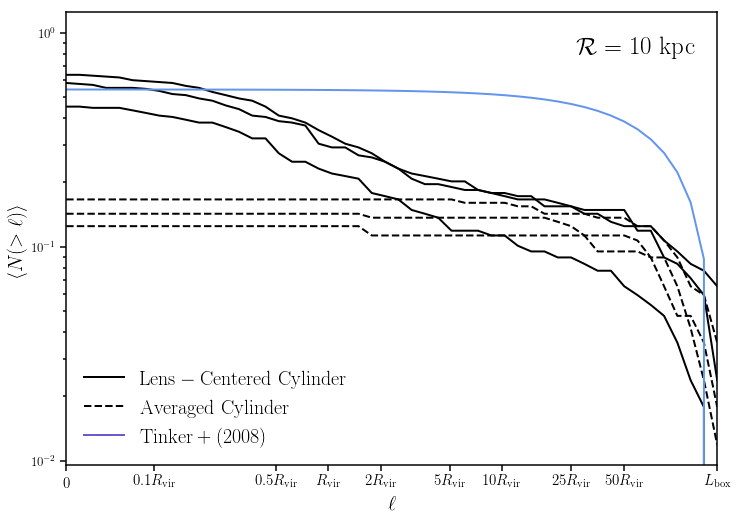

In [66]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(ln1, xa1, color='black')
ax.plot(ln1, ya1, color='black')
ax.plot(ln1, za1, color='black')
ax.plot(ln1, xra1, ls='--', color='black')
ax.plot(ln1, yra1, ls='--', color='black')
ax.plot(ln1, zra1, ls='--', color='black')

ax.plot(ln1, N_ellg1, color='cornflowerblue')

# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(ln1), max(ln1))
#ax.set_ylim(100, 2000)
 
# ---- modify tick and axis label
ax.set_xticks([min(ln1), 0.1, 0.5, 1., 2., 5., 10, 25., 50., max(ln1)])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$5 R_{\rm vir}$',r'$10 R_{\rm vir}$', 
                    r'$25 R_{\rm vir}$', r'$50 R_{\rm vir}$',r'$L_{\rm box}$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle N(>\ell) \rangle$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='slateblue', ls='-', label=r'$\rm Press-Schechter + (1974)$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Sheth-Tormen + (1999)$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='slateblue', ls='-', label=r'$\rm Tinker + (2008)$')
leg = ax.legend(loc='lower left', frameon=False, fontsize=20)

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'$\mathcal{R} = 10\ \rm kpc$'], loc="upper right", ncol=2, 
                  fontsize=25, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(leg)

In [67]:
radius2 = 10. # kpc
lBox = params['boxsize'] * 1000. # kpc
ellGpc = 10**np.linspace(0., np.log10(1e+6),50)

N_ellGpc1 = np.zeros(len(ellGpc))
for i in range(len(ellGpc)):
    volume = np.pi * radius2**2. * ellGpc[i] * np.power(1.e-3,3) / 2.
    N_ellGpc1[i] = n_cut * volume
    
N_elllGpc1 = np.cumsum(N_ellGpc1)
N_ellgGpc1 = np.max(N_elllGpc1) - N_elllGpc1
dN_ellgGpc1 = np.gradient(N_elllGpc1)/np.gradient(ellGpc)

extrap_arr = 10**np.linspace(np.log10(lBox+50000.), np.log10(1e+6),10)
noisex1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))
noisey1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))
noisez1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))
noisexr1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))
noiseyr1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))
noisezr1 = np.random.normal(max(dN_ellgGpc1), 1e-6, len(extrap_arr))

extrap_ell1 = list(dl1) + list(extrap_arr)
ext_dxa1 = list(np.abs(dxa1)) + list(noisex1)
ext_dya1 = list(np.abs(dya1)) + list(noisey1)
ext_dza1 = list(np.abs(dza1)) + list(noisez1)
ext_dxra1 = list(np.abs(dxra1)) + list(noisexr1)
ext_dyra1 = list(np.abs(dyra1)) + list(noiseyr1)
ext_dzra1 = list(np.abs(dzra1)) + list(noisezr1)

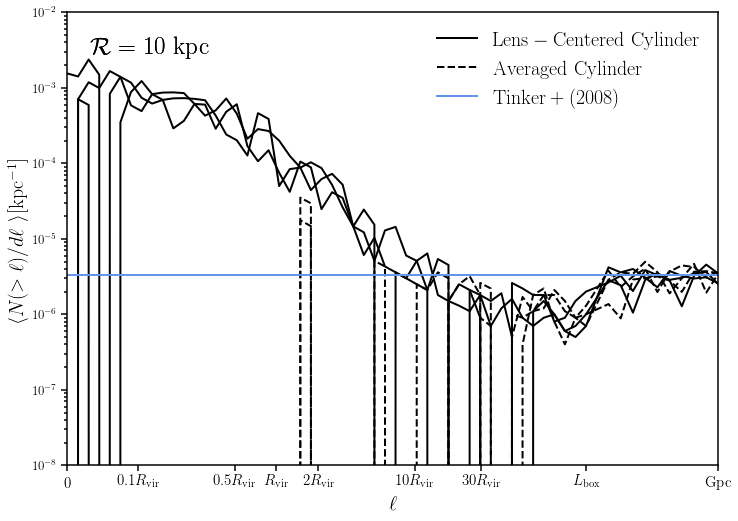

In [68]:
fig = plt.figure(figsize=(14/1.2,10/1.2))
ax = fig.add_subplot(111)
 
# ---- plotting curves
ax.plot(extrap_ell1, ext_dxa1, color='black')
ax.plot(extrap_ell1, ext_dya1, color='black')
ax.plot(extrap_ell1, ext_dza1, color='black')
ax.plot(extrap_ell1, ext_dxra1, ls='--', color='black')
ax.plot(extrap_ell1, ext_dyra1, ls='--', color='black')
ax.plot(extrap_ell1, ext_dzra1, ls='--', color='black')
 
ax.plot(ellGpc, dN_ellgGpc1, color='cornflowerblue')
 
# ---- setting plot scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(min(l), 1e+6)
ax.set_ylim(1e-8, 1e-2)
 
# ---- modify tick and axis label
ax.set_xticks([min(l), 0.1*avgR, 0.5*avgR, avgR, 2.*avgR,  10.*avgR, 30.*avgR, lBox, 1e+6])
ax.set_xticklabels([r'$0$', r'$0.1 R_{\rm vir}$', r'$0.5 R_{\rm vir}$', r'$R_{\rm vir}$', 
                    r'$2 R_{\rm vir}$', r'$10 R_{\rm vir}$', r'$30 R_{\rm vir}$', 
                    r'$L_{\rm box}$', r'$\rm Gpc$'], fontsize=15)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

ax.set_ylabel(r'$\langle N(>\ell) / d\ell\ \rangle [\rm kpc^{-1}] $', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)

# --- Generate legends on plot
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='-', label=r'$\rm Lens-Centered\ Cylinder$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='black', ls='--', label=r'$\rm Averaged\ Cylinder$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='slateblue', ls='-', label=r'$\rm Press-Schechter + (1974)$')
#ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Sheth-Tormen + (1999)$')
ax.plot(np.linspace(1,1), np.linspace(1,1), color='cornflowerblue', ls='-', label=r'$\rm Tinker + (2008)$')
leg = ax.legend(loc='upper right', frameon=False, fontsize=20)
ax.add_artist(leg)
 
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'$\mathcal{R} = 10\ \rm kpc$'], loc="upper left", ncol=2, 
                  fontsize=25, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)


<div class="alert alert-block alert-success">
     <font size="4"> <b> Integrating the Mass Function </b> </font> 
</div>

To calculate the number of detectable line-of-sight haloes, we integrate the CDM halo mass function as,

\begin{align}
\frac{N}{d\ell d\Omega} = \int_{0}^{z_{\rm max}} n(\ell,z) \frac{dV}{d\Omega dz}
\end{align}

***

***

***

<div class="alert alert-block alert-info">
     <font size="6"> <b> Statistics of Clustering -- Peebles </b> </font> 
</div>

Good overview from [Springel et al 2018](https://arxiv.org/pdf/1707.03397.pdf)





<div class="alert alert-block alert-success">
     <font size="4"> <b> Two-point Correlation Function </b> </font> 
</div>

The **two-point (2P) correlation function** $\xi(x)$ gives the excess probability relative to a Poisson distribution to find another point at distance $x = |\vec{x}_{1} - \vec{x}_{2}|$ around a given point:
\begin{align}
\xi(x) = 1 + \frac{\langle N(x+dx) \rangle}{N_{\rm Poisson}(x+dx)}
\end{align}

The (2P) correlation can also be defined as the average contrast over the density field in real space:
\begin{align}
\xi(x) = \langle \delta(\vec{x}') \delta(\vec{x} - \vec{x}')\rangle
\end{align}
where the density preturbation field $\delta$ is defined as excess overdensity over the mean background density:
\begin{align}
\delta(\vec{x}) = \frac{\rho(\vec{x}) - \overline{\rho}}{\overline{\rho}}
\end{align}
The density field is assumed to be a _homogeneous_ and _isotropic_, **Gaussian random field**.

The clustering can be analyzed in Fourier space
\begin{align}
\delta(\vec{k}) = \frac{1}{(2\pi)^{3}} \int d^{3}x\ \delta(\vec{x}) e^{-i k_{j}x^{j}}
\end{align}



<div class="alert alert-block alert-success">
     <font size="4"> <b> Power Spectrum</b> </font> 
</div>

The **Linear power spectrum** is the Fourier transform of the 2PC function
\begin{align}
\xi_{\rm lin}(x) = \int d^{3}k\ P_{\rm lin} \frac{\sin(kx)}{kx}
\end{align}

Here the power spectrum can then be defined as the mean expected power per mode
\begin{align}
P_{\rm lin}(k) = \langle \delta_{k}\delta_{k'} \rangle 
\end{align}




<div class="alert alert-block alert-success">
     <font size="4"> <b> Spectrum Bias </b> </font> 
</div>

